###**AGrow-ML**

This notebook implements a machine learning based system to predict the production of an organic syrup in 10 different provinces in a country using data from January 2015 to Decemeber 2020. 

Different models are implemented and are evaluated using MAPE (Mean Absolute Percentage Error and R2 score.

In [2]:
# Importing essential libraries
import array
import numpy as np
import json
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

In [3]:
# Mounting drive to import data saved in the drive
from google.colab import drive
drive.mount('/content/drive')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

Mounted at /content/drive


In [4]:
# Creating dataframes to store the data files
df = pd.read_csv("drive/My Drive/gro_homework/Production Quantity.csv")
df2 = pd.read_csv("drive/My Drive/gro_homework/Daily Precipitation.csv")
df3 = pd.read_csv("drive/My Drive/gro_homework/Daily Soil Mositure.csv")
df4 = pd.read_csv("drive/My Drive/gro_homework/Daily Temperature.csv")
df5 = pd.read_csv("drive/My Drive/gro_homework/Eight Day NDVI.csv")

# Creating one single dataframe (to be used as training dataset) combining columns from other dataframes
df["Daily Precipitation"] = df2['precip']
df["smos"] = df3['smos']
df["temp"] = df4['temp']
df["ndvi"] = df5["ndvi"]

In [5]:
# Printing the first 5 rows in the dataframe
df.head()

,start_date,end_date,prod,region_id,Daily Precipitation,smos,temp,ndvi
0,2015-01-01T00:00:00.000Z,2015-01-31T00:00:00.000Z,171725,93,1.392393,0.310787,24.707605,0.679106
1,2015-02-01T00:00:00.000Z,2015-02-28T00:00:00.000Z,188325,93,0.315380,0.192271,26.421176,0.701431
2,2015-03-01T00:00:00.000Z,2015-03-31T00:00:00.000Z,247856,93,2.347846,0.265683,24.305642,0.745149
3,2015-04-01T00:00:00.000Z,2015-04-30T00:00:00.000Z,282791,93,21.466357,0.265683,25.142744,0.747391
4,2015-05-01T00:00:00.000Z,2015-05-31T00:00:00.000Z,291057,93,32.823651,0.230782,23.653173,0.768325


In [6]:
# Printing the last 5 rows in the dataframe
df.tail(10)

,start_date,end_date,prod,region_id,Daily Precipitation,smos,temp,ndvi
710,2020-03-01T00:00:00.000Z,2020-03-31T00:00:00.000Z,35057,105,28.985492,0.471689,30.453544,0.734155
711,2020-04-01T00:00:00.000Z,2020-04-30T00:00:00.000Z,45208,105,29.434560,0.471689,30.930928,0.737936
712,2020-05-01T00:00:00.000Z,2020-05-31T00:00:00.000Z,42796,105,1.640333,0.381587,29.376070,0.751446
713,2020-06-01T00:00:00.000Z,2020-06-30T00:00:00.000Z,57392,105,7.903649,0.381587,30.799657,0.774196
714,2020-07-01T00:00:00.000Z,2020-07-31T00:00:00.000Z,56995,105,4.455013,0.298528,30.304745,0.775190
715,2020-08-01T00:00:00.000Z,2020-08-31T00:00:00.000Z,57818,105,3.991975,0.235572,29.567768,0.786163
716,2020-09-01T00:00:00.000Z,2020-09-30T00:00:00.000Z,57474,105,1.446231,0.235572,28.392562,0.787894
717,2020-10-01T00:00:00.000Z,2020-10-31T00:00:00.000Z,51821,105,0.042081,0.183680,28.026801,0.793883
718,2020-11-01T00:00:00.000Z,2020-11-30T00:00:00.000Z,44947,105,0.084165,0.218011,28.488420,0.825074
719,2020-12-01T00:00:00.000Z,2020-12-31T00:00:00.000Z,35728,105,0.287616,0.217873,25.655829,0.773762


In [7]:
# Printing the whole dataframe and also the size of the dataframe
df

,start_date,end_date,prod,region_id,Daily Precipitation,smos,temp,ndvi
0,2015-01-01T00:00:00.000Z,2015-01-31T00:00:00.000Z,171725,93,1.392393,0.310787,24.707605,0.679106
1,2015-02-01T00:00:00.000Z,2015-02-28T00:00:00.000Z,188325,93,0.315380,0.192271,26.421176,0.701431
2,2015-03-01T00:00:00.000Z,2015-03-31T00:00:00.000Z,247856,93,2.347846,0.265683,24.305642,0.745149
3,2015-04-01T00:00:00.000Z,2015-04-30T00:00:00.000Z,282791,93,21.466357,0.265683,25.142744,0.747391
4,2015-05-01T00:00:00.000Z,2015-05-31T00:00:00.000Z,291057,93,32.823651,0.230782,23.653173,0.768325
...,...,...,...,...,...,...,...,...
715,2020-08-01T00:00:00.000Z,2020-08-31T00:00:00.000Z,57818,105,3.991975,0.235572,29.567768,0.786163
716,2020-09-01T00:00:00.000Z,2020-09-30T00:00:00.000Z,57474,105,1.446231,0.235572,28.392562,0.787894
717,2020-10-01T00:00:00.000Z,2020-10-31T00:00:00.000Z,51821,105,0.042081,0.183680,28.026801,0.793883
718,2020-11-01T00:00:00.000Z,2020-11-30T00:00:00.000Z,44947,105,0.084165,0.218011,28.488420,0.825074


In [8]:
# Creating a test dataset to predict the production quantites
df_pred_temp = pd.read_csv("drive/My Drive/gro_homework/predicted_production_qty.csv", usecols = ['start_date','end_date', 'region_id'])

df_pred_temp["Daily Precipitation"] = df2['precip']
df_pred_temp["smos"] = df3['smos']
df_pred_temp["temp"] = df4['temp']
df_pred_temp["ndvi"] = df5["ndvi"]

In [9]:
# Printing the first 5 rows in the test set dataframe
df_pred_temp.head()

,start_date,end_date,region_id,Daily Precipitation,smos,temp,ndvi
0,2021-01-01T00:00:00.000Z,2021-01-31T00:00:00.000Z,93,1.392393,0.310787,24.707605,0.679106
1,2021-02-01T00:00:00.000Z,2021-02-28T00:00:00.000Z,93,0.315380,0.192271,26.421176,0.701431
2,2021-03-01T00:00:00.000Z,2021-03-31T00:00:00.000Z,93,2.347846,0.265683,24.305642,0.745149
3,2021-04-01T00:00:00.000Z,2021-04-30T00:00:00.000Z,93,21.466357,0.265683,25.142744,0.747391
4,2021-05-01T00:00:00.000Z,2021-05-31T00:00:00.000Z,93,32.823651,0.230782,23.653173,0.768325


In [10]:
# Printing the test set dataframe and its size
df_pred_temp

,start_date,end_date,region_id,Daily Precipitation,smos,temp,ndvi
0,2021-01-01T00:00:00.000Z,2021-01-31T00:00:00.000Z,93,1.392393,0.310787,24.707605,0.679106
1,2021-02-01T00:00:00.000Z,2021-02-28T00:00:00.000Z,93,0.315380,0.192271,26.421176,0.701431
2,2021-03-01T00:00:00.000Z,2021-03-31T00:00:00.000Z,93,2.347846,0.265683,24.305642,0.745149
3,2021-04-01T00:00:00.000Z,2021-04-30T00:00:00.000Z,93,21.466357,0.265683,25.142744,0.747391
4,2021-05-01T00:00:00.000Z,2021-05-31T00:00:00.000Z,93,32.823651,0.230782,23.653173,0.768325
...,...,...,...,...,...,...,...
115,2021-08-01T00:00:00.000Z,2021-08-31T00:00:00.000Z,105,16.081838,0.342948,26.180476,0.820244
116,2021-09-01T00:00:00.000Z,2021-09-30T00:00:00.000Z,105,13.078475,0.342948,25.227254,0.765511
117,2021-10-01T00:00:00.000Z,2021-10-31T00:00:00.000Z,105,5.453590,0.242948,26.979744,0.814645
118,2021-11-01T00:00:00.000Z,2021-11-30T00:00:00.000Z,105,13.232304,0.275283,27.732059,0.810593


In [11]:
# Random Forest Implementation
x = df[['region_id','Daily Precipitation','smos','temp','ndvi']]
y = df['prod']

# Splitting in train and validation sets
X_train, X_val, y_train, y_val = train_test_split(x, y, train_size=0.80)

random_forest_regressor = RandomForestRegressor(n_estimators = 100, random_state = 0, verbose = 10)
random_forest_regressor.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestRegressor(random_state=0, verbose=10)

In [12]:
# Predicting the values
y_pred = random_forest_regressor.predict(X_train)
y_pred

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array([187259.17,  56654.41, 285690.35,  44566.73,  64751.05, 241642.43,
       298282.18,  31329.47,  26775.08,  25508.09, 136680.34, 128926.65,
       157939.78, 398954.61,  51083.98,  30042.63, 414257.54,  47982.95,
       145574.27, 438377.84, 144670.53, 336301.54,  16076.81, 207543.46,
        17264.8 , 236472.86, 363719.41, 161375.69, 164623.07,  48314.19,
        48000.6 , 230749.33,  45194.4 ,  57101.14,  35131.98,  28374.07,
       246717.9 ,  49242.55, 362686.01, 400855.61,  25170.07,  15516.58,
       254515.51, 264574.62, 322441.7 , 422372.35, 433815.63, 388116.05,
       436608.12,  18113.64, 131672.63,  28379.85,  50427.12, 196871.18,
        30638.74,  25838.86,  45335.08,  43347.47,  34555.96,  43131.7 ,
        35063.87,  24830.23,  45173.12, 448693.97,  43731.08,  24527.23,
        49080.85, 271561.92,  28630.29,  20477.14, 346545.02,  44896.76,
        41738.1 , 176390.06,  27457.37,  23034.17, 148072.21, 225411.64,
       144685.05,  21128.97, 363639.7 , 255989.57, 

In [13]:
# Calculating Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(y_train, y_pred)
print(mape)

0.06558996982664125


In [14]:
# Calculating R2 Score
r2 = r2_score(y_train, y_pred)
print(r2)

0.9922270288119155


In [16]:
# Support Vector Regressor Implementation

svr = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-1, loss="epsilon_insensitive"))
svr.fit(X_train, y_train)

# Predicting values 
y_pred_svr = svr.predict(X_train)

# Calculating Mean Absolute Percentage Error
mape_svr = mean_absolute_percentage_error(y_train, y_pred_svr)
print(mape_svr)

# Calculating R2 Score
r2_svr = r2_score(y_train, y_pred_svr)
print(r2_svr)

0.9893178156193903
-1.1976900150949277


In [17]:
# Decision Tree Regressor Implementation

regressor = DecisionTreeRegressor(random_state=0, max_depth = 10)
regressor.fit(X_train, y_train)

# Predicting values 
y_pred_regressor = regressor.predict(X_train)

# Calculating Mean Absolute Percentage Error
mape_regressor = mean_absolute_percentage_error(y_train, y_pred_regressor)
print(mape_regressor)

# Calculating R2 Score
r2_regressor = r2_score(y_train, y_pred_regressor)
print(r2_regressor)

0.06335683231063653
0.9916443763944602


In [18]:
# Importing essential libraries
# Neural network Implementation

import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.2


In [19]:
# Finding columns with NULL values
df.isna().sum()

start_date             0
end_date               0
prod                   0
region_id              0
Daily Precipitation    0
smos                   0
temp                   0
ndvi                   0
dtype: int64

In [20]:
# Dropping columns with NULL values
df = df.dropna()

In [21]:
# Printing the last 5 rows of the dataframe
df.tail()

,start_date,end_date,prod,region_id,Daily Precipitation,smos,temp,ndvi
715,2020-08-01T00:00:00.000Z,2020-08-31T00:00:00.000Z,57818,105,3.991975,0.235572,29.567768,0.786163
716,2020-09-01T00:00:00.000Z,2020-09-30T00:00:00.000Z,57474,105,1.446231,0.235572,28.392562,0.787894
717,2020-10-01T00:00:00.000Z,2020-10-31T00:00:00.000Z,51821,105,0.042081,0.183680,28.026801,0.793883
718,2020-11-01T00:00:00.000Z,2020-11-30T00:00:00.000Z,44947,105,0.084165,0.218011,28.488420,0.825074
719,2020-12-01T00:00:00.000Z,2020-12-31T00:00:00.000Z,35728,105,0.287616,0.217873,25.655829,0.773762


In [22]:
# Printing the dataframe and the size of the dataframe
df

,start_date,end_date,prod,region_id,Daily Precipitation,smos,temp,ndvi
0,2015-01-01T00:00:00.000Z,2015-01-31T00:00:00.000Z,171725,93,1.392393,0.310787,24.707605,0.679106
1,2015-02-01T00:00:00.000Z,2015-02-28T00:00:00.000Z,188325,93,0.315380,0.192271,26.421176,0.701431
2,2015-03-01T00:00:00.000Z,2015-03-31T00:00:00.000Z,247856,93,2.347846,0.265683,24.305642,0.745149
3,2015-04-01T00:00:00.000Z,2015-04-30T00:00:00.000Z,282791,93,21.466357,0.265683,25.142744,0.747391
4,2015-05-01T00:00:00.000Z,2015-05-31T00:00:00.000Z,291057,93,32.823651,0.230782,23.653173,0.768325
...,...,...,...,...,...,...,...,...
715,2020-08-01T00:00:00.000Z,2020-08-31T00:00:00.000Z,57818,105,3.991975,0.235572,29.567768,0.786163
716,2020-09-01T00:00:00.000Z,2020-09-30T00:00:00.000Z,57474,105,1.446231,0.235572,28.392562,0.787894
717,2020-10-01T00:00:00.000Z,2020-10-31T00:00:00.000Z,51821,105,0.042081,0.183680,28.026801,0.793883
718,2020-11-01T00:00:00.000Z,2020-11-30T00:00:00.000Z,44947,105,0.084165,0.218011,28.488420,0.825074


In [23]:
# Segregating columns in features --> x, label --> y
x = df[['region_id','Daily Precipitation','smos','temp','ndvi']]
y = df['prod']

# splitting in train and validation sets
X_train, X_val, y_train, y_val = train_test_split(x, y, train_size=0.80)

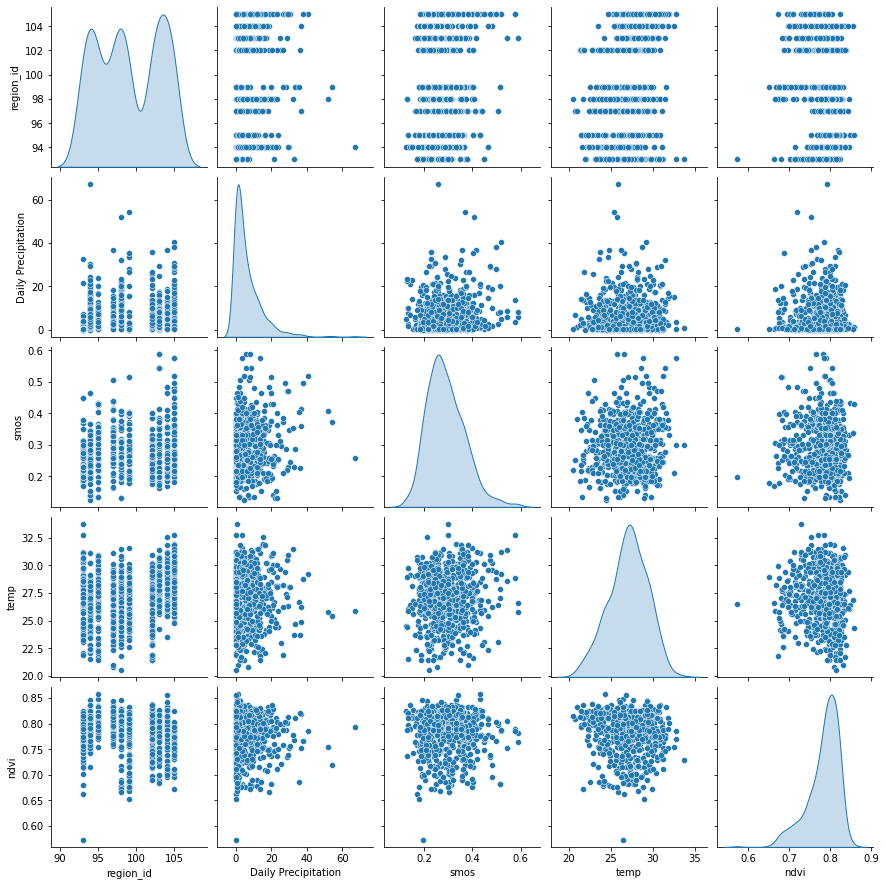

In [24]:
# Pairplot 
sns.pairplot(df[['region_id','Daily Precipitation','smos','temp','ndvi']], diag_kind='kde')

In [25]:
# Using the describe() to find useful stats for the numeric columns
x.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
region_id,720.0,99.000000,4.101630,93.000000,95.000000,98.500000,103.000000,105.000000
Daily Precipitation,720.0,6.338860,7.969791,0.000067,0.634289,3.472216,9.093432,67.223033
smos,720.0,0.290631,0.077984,0.126443,0.235572,0.278911,0.339133,0.588049
temp,720.0,27.054364,2.304648,20.571460,25.623223,27.197225,28.734890,33.710834
ndvi,720.0,0.783307,0.038465,0.573141,0.765453,0.792154,0.810870,0.857447


In [26]:
# Printing only Mean and Standard Deviation of the data
x.describe().transpose()[['mean', 'std']]

,mean,std
region_id,99.000000,4.101630
Daily Precipitation,6.338860,7.969791
smos,0.290631,0.077984
temp,27.054364,2.304648
ndvi,0.783307,0.038465


In [27]:
# Normalizing the data

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
normalizer.adapt(np.array(y_train))

In [28]:
# Printing the training labels
y_train

70     246388
561    432846
538    383422
484    411822
656     52581
        ...  
213     34090
696     44399
203     19797
318    266409
96      15526
Name: prod, Length: 576, dtype: int64

In [29]:
# Normalizing the first element of x-train as an example
first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[93.    0.02  0.2  26.48  0.57]]

Normalized: [[-1.12 -1.12 -1.12 -1.12 -1.12]]


In [30]:
# Building the network
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(512, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [31]:
# Printing the model
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 512)               131584    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                        

In [32]:
# Running the Model
%%time
history = dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.2, epochs=500)

Epoch 1/500
15/15 [==============================] - 1s 25ms/step - loss: 46099550208.0000 - val_loss: 43318497280.0000
Epoch 2/500
15/15 [==============================] - 0s 9ms/step - loss: 46037340160.0000 - val_loss: 43050442752.0000
Epoch 3/500
15/15 [==============================] - 0s 10ms/step - loss: 44761985024.0000 - val_loss: 38762852352.0000
Epoch 4/500
15/15 [==============================] - 0s 9ms/step - loss: 32951951360.0000 - val_loss: 17462773760.0000
Epoch 5/500
15/15 [==============================] - 0s 11ms/step - loss: 21970548736.0000 - val_loss: 17887983616.0000
Epoch 6/500
15/15 [==============================] - 0s 9ms/step - loss: 20894574592.0000 - val_loss: 17495683072.0000
Epoch 7/500
15/15 [==============================] - 0s 9ms/step - loss: 21193199616.0000 - val_loss: 17796296704.0000
Epoch 8/500
15/15 [==============================] - 0s 11ms/step - loss: 21023510528.0000 - val_loss: 17430212608.0000
Epoch 9/500
15/15 [=========================

In [33]:
# Calculating predictions for the validation dataset
val_predictions = dnn_model.predict(X_train).flatten()

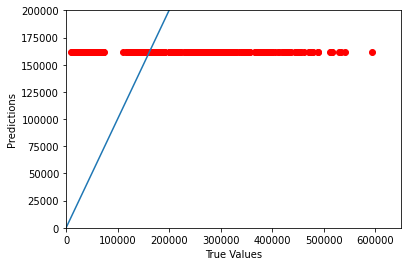

In [49]:
# Plot between Validation Predictions and True Values 
#a = plt.axes(aspect='equal')
plt.scatter(y_train, val_predictions, c = 'red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 650000]
y_lims = [0, 200000]
plt.xlim(lims)
plt.ylim(y_lims)
_ = plt.plot(lims, lims)

In [64]:
# Function to plot Error vs Epochs for training and validation loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([15858306560, 25858306560])
  plt.xlim([0, 500])
  plt.xlabel('Epoch')
  plt.ylabel('Error [prod]')
  plt.legend()
  plt.grid(True)

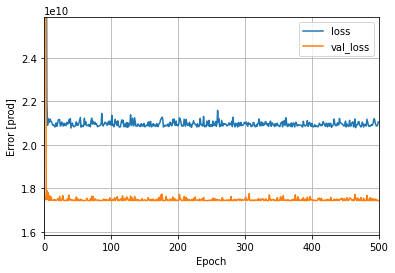

In [65]:
plot_loss(history)